## Data Analyst P3 - Jasper Alblas

## Introduction

The aim of this project is to investigate an area from OpenStreetMaps, by auditing its XML data. If any problems arise these should be fixed while converting the dataset in seperate csv files, before finally inserting the data into a SQL database.


## Table of Contents

#### 1. Fetching the data from OpenStreetMap
#### 2. Auditing the data in Python
#### 3. Fixing the data & converting to csv
#### 4. Inserting in SQL Database
#### 5. Run queries

## 1. Fetching the data from OpenStreetMap

For this study I have selected the area in the Netherlands which I grew up in. The following map shows the study area in the southwest of the country:

<img src="area.png">

This dataset is downloaded from https://mapzen.com/data/metro-extracts/.
Since this is a custom extract I cannot provide a direct link to the dataset, but I provided a screenshot called "dataset_size" which shows the compressed file size is 20mb. The uncompressed XML file of this area is 380 MBs large, which is fairly large.

For this reason I will take a smaller sample while auditing the data to reduce processing time. The following code is used, from the Udacity SQL For Data Analyst Project Details. 

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET

OSM_FILE = "middendelfland.osm"
SAMPLE_FILE = "sample.osm"

k = 50 # Parameter: take every k-th top level element
chosenFile = "middendelfland.osm"  # Variable to change when running the final code on the whole dataset

def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag

    Reference:
    http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python
    """
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


with open(SAMPLE_FILE, 'wb') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')

    # Write every kth top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8'))

    output.write('</osm>')

This script uses a value of k to set the sample proportion, with higher values meaning that only every Kth value gets selected in the sample. For example, a k value of 10 would lead to a sample with only approximately 10% of all elements. Throughout this project I have gradually decreased k value, to increase the sample size, before running the final code on the whole XML dataset.

## Auditing the data in Python

Now it's time to start auditing the data in Python. To do this I will create functions to loop through and investigate the dataset. If problems are found, further functions are created to deal with cleaning the data. These will be used while converting the data to csv. 

Let's start by having a quick look at the total number of different tags in the sample.

In [2]:
from collections import defaultdict
    
def count_elements(filename):
    """Counts all elements in XML dataset"""
    count = defaultdict(set)
    
    # Since the dataset is large, we will use iterparse instead of using the parse method 
    # (which gets the whole tree at once)
    
    for event, elem in ET.iterparse(filename, events=("start","end")):
        if event == "start":
            #print elem
            tag = elem.tag
            #print elem.tag, elem.attrib
        
            if tag in count:
                count[tag] += 1
            else:
                count[tag] = 1
            elem.clear()
    return count

In [3]:
count_elements(chosenFile)

defaultdict(set,
            {'bounds': 1,
             'member': 18097,
             'nd': 1779717,
             'node': 1415637,
             'osm': 1,
             'relation': 1725,
             'tag': 2262298,
             'way': 221651})

As we can see, the most common XML element is "tag". This is no surpise as this element is used to describe "node", "way" and "relation" elements. All other elements are typical for OpenStreetMap datasets (https://wiki.openstreetmap.org/wiki/Elements), so this does not indicate any problems. In this study I will focus on the "node" and "way" elements, including their underlying elements.

## The node element

Now that we have taken a look at the number of elements, let's have a look at the other type of element that is of interest, nodes. These describe a specific point of space on the earth's surface defined by its latitude and longitude.

A typical node looks like this:

* node {'changeset': '21644925', 'uid': '1892873', 'timestamp': '2014-04-12T12:07:47Z', 'lon': '4.3676075', 'version': '1', 'user': 'opani_BAG', 'lat': '51.9405121', 'id': '2785239869'}

On first sight, the information worth checking out is its coordinates. Do the coordinates fall within an expected range of value within this area in the Netherlands.

In [4]:
def checkForBadCoordinates(file):
    """Loops through the latittude and longitude keys of all nodes in file to check if they are in expected range"""
    badLocations = []
    for event, element in ET.iterparse(file, events=("start","end")):
        if element.tag == "node":
            if event == "start":
                if 'lat' and 'lon' in element.attrib:
                    lat = float(element.attrib['lat'])
                    lon = float(element.attrib['lon'])
                
                    # http://www.mapsofworld.com/lat_long/netherlands-lat-long.html
                    if not (lat > 51 and lat < 52,5) and (lon > 4 and lon < 5):
                        print "{0}, {1}".format(lat, lon)
                        badLocations.append(value)
            element.clear()
    return badLocations

checkForBadCoordinates(chosenFile)

[]

As can be seen, no values exists outside of the defined expected area of coordinates.
Now let's have a quick look at the number of unique users, with the total amount of entries counted for each.

In [5]:
def uniqueUsers(filename):
    """Lists all unique users of file and counts their contributions"""
    users = defaultdict(int)
    for event, element in ET.iterparse(filename, events=("start","end")):
        if event == "end":
            if 'uid' in element.attrib:
                value = element.attrib['uid']
                users[value] += 1
            element.clear()
    return [(k, users[k]) for k in sorted(users, key=users.get, reverse=True)]

In [6]:
uniqueUsers(chosenFile)[:10]

[('1892873', 740109),
 ('1204291', 313019),
 ('195219', 168920),
 ('36080', 48718),
 ('1989776', 38150),
 ('327477', 35587),
 ('579978', 35046),
 ('191979', 34932),
 ('2005379', 33827),
 ('568540', 18801)]

As can be seen, there is a relativly large number of users which inserted only a few values into the dataset, while there is a small number of users responsible for a great amount of data entered. Again, nothing seems out of the ordinary here.

## The way element

Now, let's have a look at the "way" elements. A typical element looks like this: 

* way {'changeset': '27415982', 'uid': '2394881', 'timestamp': '2014-12-12T08:00:03Z', 'version': '3', 'user': "It's so funny_mechanical", 'id': '138652513'}

In my opinion, there is nothing really of interest here for auditing. Even if there were errors here in the timestamp or user ID values, it would not mean much for the remainder of this report.

## The nd element

"nd" elements are nested within "way" elements, to identify which "node" elements are a part of a "way, e.g. a linear path. 

* nd {'ref': '1520353919'}

We could theoratically check if the node this "ref" value is referring to exists in the dataset, but this would be demanding and there is no guarantee that all nodes of the "way" exist in this dataset. I will therefore move on to the "tag" element, which covers the most information.

## The tag element

This element provides the most information of all elements. It is nested within "node", "way", and "relation" elements and describe the meaning of an element to which they are attached. The following are examples of some tags nested within a "node" element:

tag {'k': 'source', 'v': 'BAG 04-10-2013'}

tag {'k': 'addr:city', 'v': 'De Lier'}

tag {'k': 'addr:street', 'v': 'Hohorst'}

tag {'k': 'addr:country', 'v': 'NL'}

tag {'k': 'addr:postcode', 'v': '2678CC'}

tag {'k': 'addr:province', 'v': 'Zuid-Holland'}

tag {'k': 'addr:housenumber', 'v': '37'}

tag {'k': 'bag:gebruiksfunctie', 'v': 'woonfunctie'}

It would be interesting to see which tag keys are the most common.

In [7]:
def uniqueTagKeys(osmfile):
    """Lists all unique tag keys and their frequency"""
    osm_file = open(osmfile, "r")
    keyValues = defaultdict(int)
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                keyValues[tag.attrib["k"]] += 1
                
    osm_file.close()
    return [(k, keyValues[k]) for k in sorted(keyValues, key=keyValues.get, reverse=True)]


uniqueTagKeys(chosenFile)[:10]

[('source', 385338),
 ('source:date', 362864),
 ('addr:city', 202883),
 ('addr:street', 202600),
 ('addr:postcode', 201113),
 ('addr:housenumber', 201096),
 ('building', 165372),
 ('ref:bag', 164128),
 ('start_date', 163308),
 ('highway', 31248)]

I will now have a closer look to some of the most common keys, starting with source. If problems are found, a function will be created to fix the errors.

### Auditing source

I will now have a look at the data sources. I will create a function which I can reuse for further auditing which lists a count of all unique values.

In [8]:
def uniqueTagValues(osmfile, key):
    """Lists all unique tag values for a specific key and their frequency"""
    osm_file = open(osmfile, "r")
    tagValues = defaultdict(int)
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if tag.attrib["k"] == key:
                    tagValues[tag.attrib["v"]] += 1
    osm_file.close()
    return [(k, tagValues[k]) for k in sorted(tagValues, key=tagValues.get, reverse=True)]

In [9]:
uniqueSources = uniqueTagValues(chosenFile, "source")

uniqueSources[:10]

[('BAG', 365937),
 ('3dShapes', 12991),
 ('survey', 1978),
 ('Bing', 1695),
 ('local_knowledge', 837),
 ('BAG 04-10-2013', 371),
 ('Veolia Transport', 319),
 ('AND', 134),
 ('3dShapes;BAG', 130),
 ('Wiki.ovinnederland.nl', 74)]

As can be seen, some source values include the actual source, followed by a date. I will try and fix this by removing this date from the source, and adding it to the "source:date" key instead, including transforming to the proper format. If this key already exists I will not change anything, while I will create this value if this is not the case.

In [10]:
from datetime import datetime
import re

def checkForDateAndReturnValues(sourceValue):
    """Looks if date is found in source, and returns fixed source and extracted date"""
    result = re.search('(\d{2})[/.-](\d{2})[/.-](\d{4})$', sourceValue)
    if result:
        # Return the value matched to add it to source:date
        date = result.groups(0)
        
        oldString = "{2}-{1}-{0}".format(date[2],date[1],date[0])
        formattedString = "{2}-{1}-{0}".format(date[0],date[1],date[2])
        
        # Remove from source
        fixedLocation = sourceValue.replace(oldString, "")
        
        return (fixedLocation, formattedString)
    else:
        return None

# Do a quick test
for key,value in uniqueSources:
    values = checkForDateAndReturnValues(key)
    if values: 
        print values
        

('BAG ', '2013-10-04')
('Bing/WorldView-2,DigitalGlobe,Nextview,04/18/2011', '2011-18-04')


This function will be used while transforming the data to csv later on.

### Auditing source date

I will now look at the source dates. I would expect to see all dates follow the following format YYYY-MM-DD, which I will use a regular expression for to test. In addition I will check if the field only includes 10 characters.

In [11]:
uniqueDates = uniqueTagValues(chosenFile, "source:date")

for key,value in uniqueDates:
    if not re.search('(\d{4})[/.-](\d{2})[/.-](\d{2})$', key):
          print key
    if len(key) != 10:
        print key

2013-11-26 + 2014-02-19
2013-09-01;2013-11-26
2013-11-26 + local knowledge
2013-11-26 + local knowledge
2013-11-26;survey
2013-11-26;survey
2013-11-26,2014-10-29


There are only a few problems with the values (with bigger sample sizes!), with either multiple dates added or the source added to the value (actually the opposite issue of last section!). In case there are multiple dates, I will remove the oldest value, since I feel listing the date of the last update makes the most sense. If there is other data I will remove it. I could have added the string to the source key like in the previous section, but it will be hard to check if the remainder actually is a source or something else. 

In [12]:
def cleanSourceDateElement(sourceValue):
    """Looks if source date includes multiple date and picks most recent. Removes all other text."""
    twoDates = re.search('((\d{4}[/.-]\d{2}[/.-]\d{2})[,;](\d{4}[/.-]\d{2}[/.-]\d{2}))$', sourceValue)
    oneDate = re.search('(\d{4}[/.-]\d{2}[/.-]\d{2})$', sourceValue)
    
    if twoDates:
        # Return the value matched to add it to source:date  
        date = twoDates.groups(0)
        dt1 = datetime.strptime(date[1],'%Y-%m-%d')
        dt2 = datetime.strptime(date[2],'%Y-%m-%d')
        
        if dt1 > dt2:
            return date[1]
        else: 
            return date[2]
    elif oneDate:
        # Check for only one date
        date = oneDate.groups(0)
        return date[0]
    else:
        return None

### Auditing country code

Although I don't expect any issues here let's quickly look the "addr:country" key values.

In [13]:
uniqueTagValues(chosenFile, "addr:country")

[('NL', 2584)]

As expected, no problems here.

### Auditing city names

Continuing, I will make sure that all city names actually exist.

In [14]:
# Check all unique city names
uniqueCities = uniqueTagValues(chosenFile, 'addr:city')

uniqueCities

[('Delft', 55206),
 ('Vlaardingen', 38917),
 ('Schiedam', 36215),
 ('Maassluis', 16983),
 ('Naaldwijk', 7521),
 ('Wateringen', 6442),
 ('De Lier', 5850),
 ('Rozenburg', 5048),
 ("'s-Gravenhage", 4098),
 ('Rijswijk', 3786),
 ('Den Hoorn', 3591),
 ('Delfgauw', 3470),
 ('Honselersdijk', 3296),
 ('Maasland', 3130),
 ('Poeldijk', 2850),
 ('Maasdijk', 2078),
 ('Schipluiden', 2051),
 ('Kwintsheul', 1668),
 ('Rotterdam', 571),
 ("'s-Gravenzande", 69),
 ('Pijnacker', 18),
 ('Brielle', 11),
 ('Europoort Rotterdam', 8),
 ('Hoek van Holland', 6)]

To check validity, I will check each city name with a JSON file containing worldwide city names by county, found here: 

https://github.com/David-Haim/CountriesToCitiesJSON/blob/master/countriesToCities.json

In [15]:
import json

def checkCityExistence(name):
    """Takes a city names and checks in JSON file if value is known Dutch city names"""
    json_file='countriesToCities.json'

    json_data = open(json_file)
    data = json.load(json_data)
    json_data.close()

    dutchCities = data['Netherlands']
    
    if name in dutchCities:
        return True
    else:
        return False

In [16]:
for city,count in uniqueCities:
    if not checkCityExistence(city):
        print "Error found with city {0}".format(city)

Error found with city 's-Gravenhage
Error found with city Europoort Rotterdam


's-Gravenhage is actually a synonym for the name "Den Haag" so there is nothing wrong with the value. Europoort Rotterdam should technically perhaps be called Europoort, but this could be argued otherwise. These issues are not required to be changed in my opinion.

### Auditing postal codes

Postal codes are another tag that can be easily checked programatically. For this I will use a fairly forward regular expression. Since dutch postal codes have the format: 0000AA (where 0 is any number, and A is any letter), this can be checked for by the following:

In [17]:
uniqueZip = uniqueTagValues(chosenFile, "addr:postcode")
uniqueZip[:5]

[('2624WW', 301),
 ('3122VM', 279),
 ('3122XA', 278),
 ('3122VN', 277),
 ('3136EA', 250)]

In [18]:
reZip = re.compile(r'(\d{4})([A-Z]{2})')

count = 0

for key,value in uniqueZip:
    if reZip.search(key) == None:
        count += 1
        #print "Error with zip code {0}".format(key)
        
print count

205


As can be been 205 values did not follow the expected format. The wrong values are caused by a space between the group of numbers and the two letters. This is a quite common way of writing zip codes in the Netherlands, but it should be changed in the dataset for consistency sake. Since this is the only type of error, I can easily just remove all whitespace by using the python function .replace()

In [19]:
def removeWhiteSpace(element):
    """Removes whitespace between numbers and letters of zip code"""
    return element.replace(" ", "")

#To test if it works
for key,value in uniqueZip:
    if reZip.search(key) == None:
        print key
        key = removeWhiteSpace(key)
        print key
        break

2678 CL
2678CL


### Auditing street names

I will now have a look at the most common streetnames.

In [20]:
streetValues = uniqueTagValues(chosenFile, "addr:street")

I created a list of common Dutch streetname endings. The problem is, that unlike U.S. streetnames, the words are connected so it will be diifcult to use a regular expression to seperate the street type from the rest of the name. This will thus required more manual labor. Let's have a look to see which values do not include any of the common Dutch streetname words.

In [21]:
dutchStreetNames = ["straat", "dijk", "plein", "kade", "gracht", "laan", "sluis", "polder", "hof", "weg", \
                    "gaag", "singel", "dreef", "pad", "gaag", "vliet", "hoeve"]

count = 0
for key,value in streetValues:
    if not any(street in key for street in dutchStreetNames):
        count += 1

print "Total street names values: {0}".format(len(streetValues))
print "Other names: {0}".format(count)

Total street names values: 3911
Other names: 1050


As can be seen, even with excluding some of the most common Dutch streetname endings, there are still many streetname which do not include any of these. A quick audit shows that there isn't anything clearly wrong with the names so I will leave it at that.

### Auditing phone numbers

As a final tag key to audit, I have decided to take a look at the "phone" key. This key is, as the name suggests, used to add a phone number to a specific node (or way) elements. 

In [22]:
phoneNumbers = uniqueTagValues(chosenFile, "phone")
phoneNumbers[:10]

[('+3152122990', 2),
 ('0152855111', 2),
 ('+31-10-4344700', 2),
 ('+31152628160', 2),
 ('+31152611454', 2),
 ('+31 15 2136792', 2),
 ('+31174624765', 1),
 ('0152510720', 1),
 ('+31 10 4342162', 1),
 ('+31152140777', 1)]

This clearly shows that there are many different ways of formatting telephone numbers. The main issues is that some numbers add the country code (+31), which makes it a 11 character number, while others omit this value to create a number of 10 characters. This is because adding the country code removes a the first zero in the regional part of the number (often 015 or 010 in this region). The country code +31 is also sometimes written as 0031. To make matters worse some numbers include spaces, while other add brackets, or a '-'.

I will need to check if a number is in the correct format, and if it is I should correct it so all numbers are in a similar format.

In [23]:
dutchPhoneNumber = re.compile(r'(^\+[0-9]{2}|^\+[0-9]{2}\(0\)|^\(\+[0-9]{2}\)\(0\)|^00[0-9]{2}|^0)([0-9]{9}$|[0-9\-\s]{10}$)')

for number,quantity in phoneNumbers:
    strippedNumber = number.replace(" ", "")
    if not dutchPhoneNumber.match(strippedNumber):
        print strippedNumber

+3152122990
+31-10-4344700
15-2566319
31-10-4348382
+3148578870
31-10-4356759
#31152120822
+31-10-2327100
31-174-294208
+31-15-2134516
31-174-292191
+31-15-2618263
+31-181-214115
31-10-4749436
31-15-2783082
14010
+31-15-2782443
+314493250
+31-15-2782441
31-174-626638
+31-15-2565801
(015)2010205


As can be seen, this regular expression does fairly well. A great deal of these numbers are actually wrong, which could indicate a human error. I would like to be able to include those numbers which include a second "-", so I will update the regular expression.

In [24]:
dutchPhoneNumber = re.compile(r'(^\+[0-9]{2}|^\+[0-9]{2}\(0\)|^\(\+[0-9]{2}\)\(0\)|^00[0-9]{2}|^0)([0-9]{9}$|[0-9\-\s]{10}|[0-9]{2}-[0-9]{7}|[0-9]{3}-[0-9]{6}$)')

for number,quantity in phoneNumbers:
    strippedNumber = number.replace(" ", "")
    if not dutchPhoneNumber.match(strippedNumber):
        print strippedNumber

+3152122990
15-2566319
31-10-4348382
+3148578870
31-10-4356759
#31152120822
31-174-294208
31-174-292191
31-10-4749436
31-15-2783082
14010
+314493250
31-174-626638
(015)2010205


Now let's create a function that audits and cleans the number to a common format.

In [25]:
def cleanPhoneNumber(number):
    """Audits phone number and edits to common format. Returns None if number is not valid."""
    dutchPhoneNumber = re.compile(r'(^\+[0-9]{2}|^\+[0-9]{2}\(0\)|^\(\+[0-9]{2}\)\(0\)|^00[0-9]{2}|^0)([0-9]{9}$|[0-9\-\s]{10}|[0-9]{2}-[0-9]{7}|[0-9]{3}-[0-9]{6}$)')

    strippedNumber = number.replace(" ", "")
    match = dutchPhoneNumber.match(strippedNumber)

    if match:
        groups = match.groups(0)
        # ('+31', '158200269'),('0', '153646121'),('0', '15-2562267')
        # First match should be changed to +31 if 0, and second match should have '-' removed
        firstPart = groups[0]
        if firstPart == '0':
            firstPart = '+31'
        secondPart = groups[1].replace("-", "")
        return firstPart + secondPart
    else:
        return None
            
            
print cleanPhoneNumber("010-5911833")
print cleanPhoneNumber("523-432")
print cleanPhoneNumber("+31174620444")

+31105911833
None
+31174620444


### Auditing problems in tag keys

Finally, I will have a quick look at the tag keys to see if any of these have problematic characters.

In [26]:
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_|:)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    
def countKeyType(element):
    """"Tests if there are any erros in the key values of tags"""
    if element.tag == "tag":
        if element.attrib["k"]:
            value = element.attrib["k"]
            if problemchars.search(value) != None:
                keys["problemchars"] += 1
            elif lower.search(value) != None:
                keys["lower"] += 1
            elif lower_colon.search(value) != None:
                keys["lower_colon"] += 1
            else:
                keys["other"] += 1        
    return keys

def process_map(filename):

    for _, element in ET.iterparse(filename):
        keys = countKeyType(element)

    return keys

process_map(chosenFile)


{'lower': 877102, 'lower_colon': 1385065, 'other': 131, 'problemchars': 0}

This shows that there are no keys with problematic chars, which is the most important since these could cause problems while inserting to SQL. 

The "lower" and "lower_colon" results will be used in the next section, where I will convert the XML to multiple csv files. The differently types of keys will be treated differently while problematic keys will be removed.

The "other" values seem to be caused by the presence of uppercase letters, underscores, and '-'. I do not expect these to cause errors and I am not aware of any rules against these characters, so I will not fix these values.

I will create a quick function that can be used while converting the XML to csv.

In [27]:
from enum import Enum

class KeyType(Enum):
    ProblemChars = 1
    Lower = 2
    LowerColon = 3
    Other = 4

def returnKeyType(value):
    """Returns an enum that shows which type of error a tag key has"""
    if problemchars.search(value) != None:
        return KeyType.ProblemChars
    elif lower.search(value) != None:
        return KeyType.Lower
    elif lower_colon.search(value) != None:
        return KeyType.LowerColon
    else:
        return KeyType.Other      

## Fixing the data and exporting to CSV

Now I will convert the XML into csv. I will at the same time fix several issues which I have investigated in the previous chapter. These are: source keys, source date, postal codes, as well as problems in tag keys. For these I will use the earlier created functions:

- checkForDateAndReturnValues(sourceValue)
- cleanSourceDateElement(sourceValue)
- removeWhitespace(element)
- cleanPhoneNumber(number)
- returnKeyType(key)

In [28]:
import csv
import codecs
import re
import xml.etree.cElementTree as ET

import cerberus

import schema

OSM_PATH = "sample.osm"

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

SCHEMA = schema.schema

# Make sure the fields order in the csvs matches the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']


def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    """Clean and shape node or way XML element to Python dict"""

    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  # Handle secondary tags the same way for both node and way elements

    if element.tag == "node":
        for value in node_attr_fields:
            if value in element.attrib:
                node_attribs[value] = element.attrib[value]
        
        # Check tags
        for child in element.iter('tag'):
            keyValue = child.attrib['k']
            value = child.attrib['v']

            
            # If key value is source
            if keyValue == "source":
                values = checkForDateAndReturnValues(child.attrib['v'])
                if values:
                    value = values[0]
                    newDate = values[1]
                    
                    # If new date, find proper tag and set
                    for siblingTag in element.iter('tag'):
                        keyValue = siblingTag.attrib['k']
                        if keyValue == "source:date":
                            siblingTag.attrib['v'] = newDate
                
            # If key value is source date
            if keyValue == "source:date":
                cleanedSource = cleanSourceDateElement(value)
                if cleanedSource:
                    value = cleanedSource
            
            # If key value is postal code
            if keyValue == "addr:postcode":
                cleanedPostal = removeWhiteSpace(value)
                if cleanedPostal:
                    value = cleanedPostal
            
            if keyValue == "phone":
                cleanedPhone = cleanPhoneNumber(value)
                if cleanedPhone:
                    value = cleanedPhone
                else:
                    continue
                
            keyType = returnKeyType(keyValue)
            
            if keyType == KeyType.ProblemChars:
                continue
            
            seperateValues = keyValue.split(':',1)
            typeValue = ""

            if keyType == KeyType.LowerColon:
                typeValue = seperateValues[0]
                keyValue = seperateValues[1]
            else:
                typeValue="regular"
            tag = {'id': element.attrib['id'], 'key': keyValue, 'value': value, 'type': typeValue}
            tags.append(tag)
        
    elif element.tag == 'way':
        for value in way_attr_fields:
            if value in element.attrib:
                way_attribs[value] = element.attrib[value]
        
        # Check nd 
        count = 0
        for child in element.iter('nd'):
            ref = child.attrib['ref']
            tag = {'id': element.attrib['id'], 'node_id': ref, 'position': count}
            way_nodes.append(tag)
            count += 1
        
        # Check tags
        for child in element.iter('tag'):
            keyValue = child.attrib['k']
            value = child.attrib['v']
            
            # If key value is source
            if keyValue == "source":
                values = checkForDateAndReturnValues(child.attrib['v'])
                if values:
                    value = values[0]
                    newDate = values[1]
                    
                    # If new date, find proper tag and set
                    for siblingTag in element.iter('tag'):
                        keyValue = siblingTag.attrib['k']
                        if keyValue == "source:date":
                            siblingTag.attrib['v'] = newDate
                
            # If key value is source date
            if keyValue == "source:date":
                cleanedSource = cleanSourceDateElement(value)
                if cleanedSource:
                    value = cleanedSource
            
            # If key value is postal code
            if keyValue == "addr:postcode":
                cleanedPostal = removeWhiteSpace(value)
                if cleanedPostal:
                    value = cleanedPostal
            
            if keyValue == "phone":
                cleanedPhone = cleanPhoneNumber(value)
                if cleanedPhone:
                    value = cleanedPhone
                else:
                    continue
                
            keyType = returnKeyType(keyValue)
            
            if keyType == KeyType.ProblemChars:
                continue
            
            seperateValues = keyValue.split(':',1)
            typeValue = ""

            if keyType == KeyType.LowerColon:
                typeValue = seperateValues[0]
                keyValue = seperateValues[1]
            else:
                typeValue="regular"
                
            tag = {'id': element.attrib['id'], 'key': keyValue, 'value': child.attrib['v'], 'type': typeValue}
            tags.append(tag)

    if element.tag == 'node':
        return {'node': node_attribs, 'node_tags': tags}
    elif element.tag == 'way':
        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}



The following functions are from the SQL For Data Analysis section of the Wrangle OpenstreetMap by Udacity. In short, these help looping through the XML data, converting it to csv, and validate the results. 

In [29]:
# ================================================== #
#               Helper Functions                     #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


def validate_element(element, validator, schema=SCHEMA):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.iteritems())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_strings = (
            "{0}: {1}".format(k, v if isinstance(v, str) else ", ".join(v))
            for k, v in errors.iteritems()
        )
        raise cerberus.ValidationError(
            message_string.format(field, "\n".join(error_strings))
        )


class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, unicode) else v) for k, v in row.iteritems()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)


# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w') as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'w') as ways_file, \
         codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])


if __name__ == '__main__':
    # Note: Validation is ~ 10X slower. For the project consider using a small
    # sample of the map when validating.
    process_map(chosenFile, validate=False)


Everything seems fine, so now let's insert the csv files into SQL.

## 5. Inserting in SQL Database

Now that the CSV file are created, we will proceed by adding importing them into SQL. While this can be done through Python, it is quicker to use some SQLite scripts in the command prompt.

In [30]:
# Terminal commands used, with the third line run for each of the five csv files

# 1. sqlite3 elements
# 2. .mode csv
# 3. import nodes.csv
# 4 .tables

## 6. Running queries

With everything setup I can now proceed to run some queries. This could be done in the terminal, but it is easier to show of right here through Python. Let's see if everything works by creating a simple function that simply fetches a number of rows of a specific table and column. Afterwards I will do a few other queries to look at some interesting data.

In [32]:
import sqlite3
from pprint import pprint

# change this to 'sqlite_file =  Chinook_Sqlite.sqlite' if that is the file you have 
sqlite_file = 'elements'    # name of the sqlite database file

def queryDatabaseWithTableAndColumnName(tableName, columnName, limit):
    """Queries elements database with given table and column name"""
    conn = sqlite3.connect(sqlite_file)
    c = conn.cursor()

    for row in c.execute('SELECT {cn} FROM {tn} LIMIT {l}'.\
            format(tn=tableName, cn=columnName, l=limit)):
        print(row)

    conn.close()

queryDatabaseWithTableAndColumnName('nodes', "user", 10)    

(u'nimapper',)
(u'lyctkel',)
(u'lyctkel',)
(u'Med',)
(u'datalogg',)
(u"It's so funny",)
(u"It's so funny",)
(u'BikePC',)
(u'BikePC',)
(u'BikePC',)


Let's look at the number of nodes and ways elements.

In [33]:
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

c.execute('SELECT COUNT(*) FROM nodes')

result = c.fetchall()
print(result)

conn.close()


[(1415637,)]


In [34]:
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

c.execute('SELECT COUNT(*) FROM ways')

result = c.fetchall()
print(result)

conn.close()

[(221651,)]


Both these values are the same as the count I did in the start in Python, showing that all data came over.

Now let's the top 10 active users

In [35]:
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

c.execute('SELECT totalUsers.user, COUNT(*) as num FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) as totalUsers GROUP BY totalUsers.user ORDER BY num DESC LIMIT 10;')

result = c.fetchall()
pprint(result)

conn.close()

[(u'opani_BAG', 740072),
 (u"It's so funny_BAG", 312921),
 (u'3dShapes', 168919),
 (u'nimapper', 48687),
 (u'Sander H_BAG', 38148),
 (u'Sander H', 35520),
 (u'Von Humboldt', 35033),
 (u"It's so funny", 34903),
 (u'Martin Borsje_BAG', 33825),
 (u'Marc-sch', 18797)]


Let's count all tags from the most active user.

In [36]:
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

c.execute('SELECT count(*) FROM ways,ways_tags WHERE ways.id = ways_tags.id AND ways.user = "opani_BAG";')

result = c.fetchall()
pprint(result)

conn.close()

[(527587,)]


In [37]:
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

c.execute('SELECT count(*) FROM nodes,nodes_tags WHERE nodes.id = nodes_tags.id AND nodes.user = "opani_BAG";')

result = c.fetchall()
pprint(result)

conn.close()

[(736704,)]


Number of unique city names:

In [38]:
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

c.execute('SELECT cities.value, COUNT(*) as num FROM (SELECT value FROM nodes_tags WHERE type = "addr" AND key = "city"UNION ALL SELECT value FROM ways_tags WHERE type = "addr" AND key = "city") as cities GROUP BY cities.value ORDER BY num DESC LIMIT 10;')

result = c.fetchall()
pprint(result)

conn.close()

[(u'Delft', 55401),
 (u'Vlaardingen', 39089),
 (u'Schiedam', 36359),
 (u'Maassluis', 17045),
 (u'Naaldwijk', 7552),
 (u'Wateringen', 6472),
 (u'De Lier', 5873),
 (u'Rozenburg', 5065),
 (u"'s-Gravenhage", 4119),
 (u'Rijswijk', 3802)]


As a small extra, let's plot this data with pandas and seaborn.

           value    num
0          Delft  55401
1    Vlaardingen  39089
2       Schiedam  36359
3      Maassluis  17045
4      Naaldwijk   7552
5     Wateringen   6472
6        De Lier   5873
7      Rozenburg   5065
8  's-Gravenhage   4119
9       Rijswijk   3802


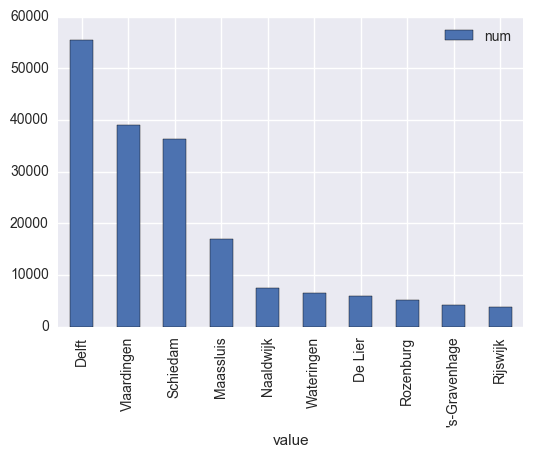

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

conn = sqlite3.connect(sqlite_file)
df = pd.read_sql_query('SELECT cities.value, COUNT(*) as num FROM (SELECT value FROM nodes_tags WHERE type = "addr" AND key = "city"UNION ALL SELECT value FROM ways_tags WHERE type = "addr" AND key = "city") as cities GROUP BY cities.value ORDER BY num DESC LIMIT 10;', conn)
conn.close()

# verify that result of SQL query is stored in the dataframe
print(df)
df = df.set_index(df["value"])

df.plot(kind="bar")

## Discussion

OpenstreetMaps hosts an enormous amount of data, which is great for data scientists. But the open source nature of the API also leads to some disadvantages. This can clearly be seen in the amount of different tag key values. Since persons are not forced to follow some strict standard concerning value formats, there seem to be a lot of keys with a low frequency. An extreme example are the source key values as seen earlier. There are so many different values, with difference between formatting, as well as persons adding multiple sources.

Another issue I came across was the mix between Dutch and English both in tag keys and tag values. An example is the land use key. Many other keys had the dutch equivalent name "gebruiksfunctie". These should definately be merged. While I did not decide to clean this up in this project, it just shows that before being able to properly use this dataset in for data analysis a lot more cleanup needs to be done, with some of these requiring manual labor.

There are also still many issues left in the most common tag key "source". While I fixed issues related to dates being appended to the date, the values for this key still included many other problems. Similar values were given slightly different names, and often there were multiple sources added after each other. If proper analysis needs to be done about the source of these keys, there is a lot of cleaning up to do.

Some of the cleaning methods in this project might not work while analyzing data in other areas in the Netherlands. It could for example be true that zip codes are written in another format which was not taken into account, but the aim in this project was to fix some of the biggest issues in relation to this specific dataset. In addition, there were many issues left unexplorered, for example house numbers.

## Conclusion

This project has shown how to convert data from different sources in to different formats, and to finally save this data in a SQL database. It has also shown how common errors can be in usergenerated data and the importance of data wrangling. In general I felt that this dataset did not have as many problems as I perhaps anticipiated, but I hope the process of auditing and cleaning data was clear from this project. 